Car Price Prediction: Data Preprocessing
Cyrus Kolahi
data download link: https://www.kaggle.com/datasets/asinow/car-price-dataset/data

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# machine learning dataloader/model
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


Data Creation

In [27]:
car_data = pd.read_csv('data/car_price_dataset.csv')
df = car_data.copy()

Data Feature Analysis

In [28]:
car_data.head()

,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


In [29]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,10000.0,2011.54370,6.897699,2000.0,2006.00,2012.0,2017.0,2023.0
Engine_Size,10000.0,3.00056,1.149324,1.0,2.00,3.0,4.0,5.0
Mileage,10000.0,149239.11180,86322.348957,25.0,74649.25,149587.0,223577.5,299947.0
Doors,10000.0,3.49710,1.110097,2.0,3.00,3.0,4.0,5.0
Owner_Count,10000.0,2.99110,1.422682,1.0,2.00,3.0,4.0,5.0
Price,10000.0,8852.96440,3112.596810,2000.0,6646.00,8858.5,11086.5,18301.0


In [30]:
# No missing data
df.isnull().sum()



Brand           0
Model           0
Year            0
Engine_Size     0
Fuel_Type       0
Transmission    0
Mileage         0
Doors           0
Owner_Count     0
Price           0
dtype: int64

In [31]:

# feature data types
df.dtypes




Brand            object
Model            object
Year              int64
Engine_Size     float64
Fuel_Type        object
Transmission     object
Mileage           int64
Doors             int64
Owner_Count       int64
Price             int64
dtype: object

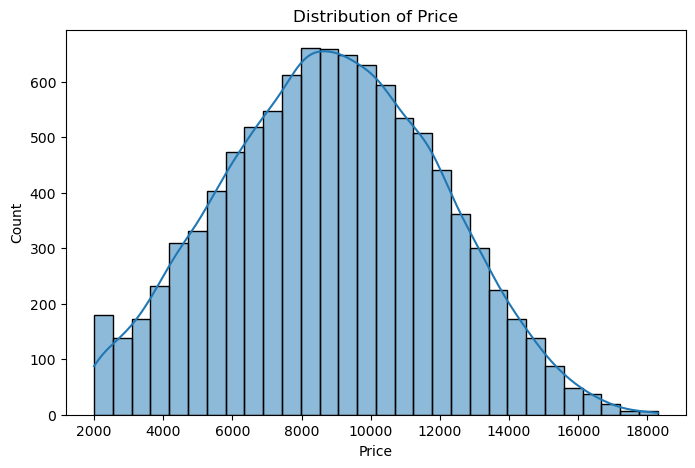

In [32]:
plt.figure(figsize=(8,5))
sns.histplot(df["Price"], bins=30, kde=True)
plt.title("Distribution of Price")
plt.show()

/var/folders/by/d52z488150xfv497p3tj2_bh0000gn/T/ipykernel_68849/2430798461.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "Year",data = df, palette = 'dark:#5A9_r')


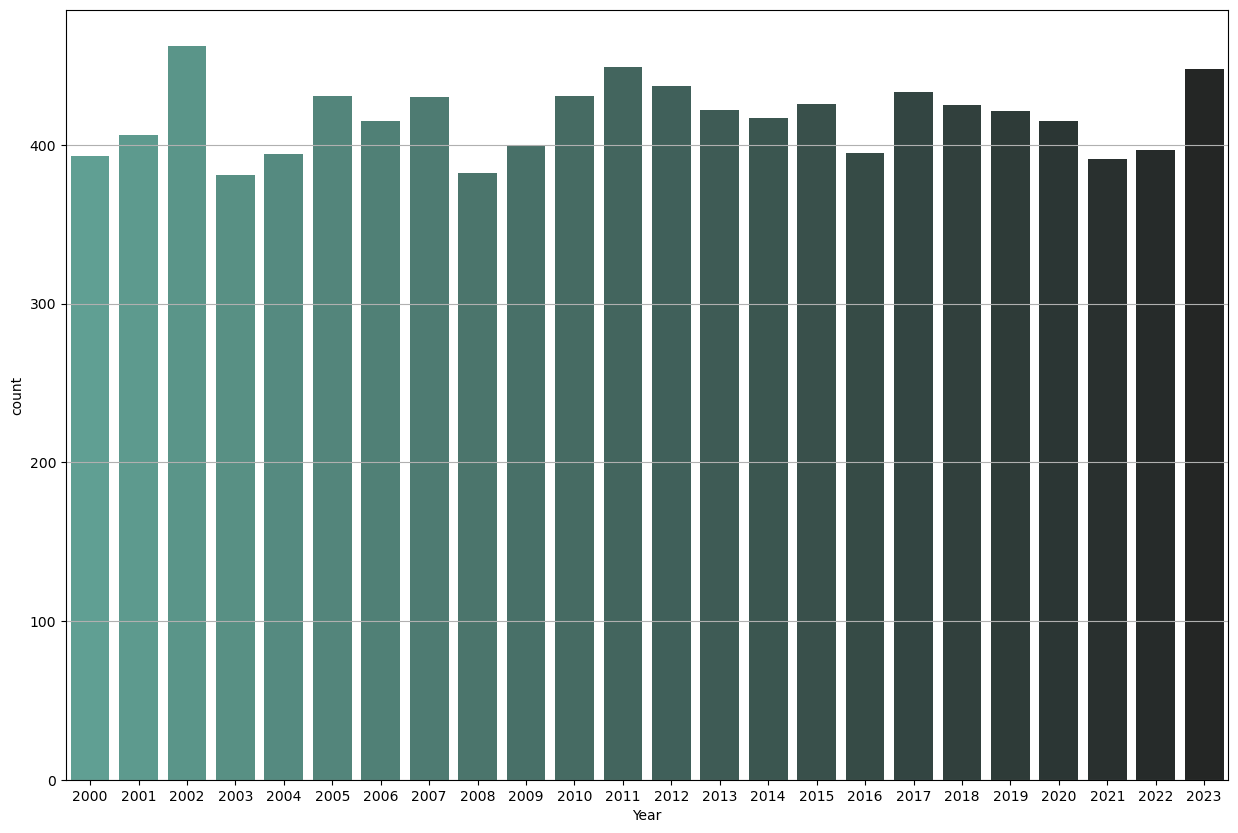

In [33]:
plt.figure(figsize = (15,10))
sns.countplot(x = "Year",data = df, palette = 'dark:#5A9_r')
plt.grid(axis = 'y')
plt.title("")
plt.show()

Just going by intuition I feel like the year feature is going to be the most significant feature in predicting the price of a car. It is good then that we have an even distribution of cars across the years. And a normal distribution of price. Below I will plot the correlation matrix of the features to cofirm this intuition.

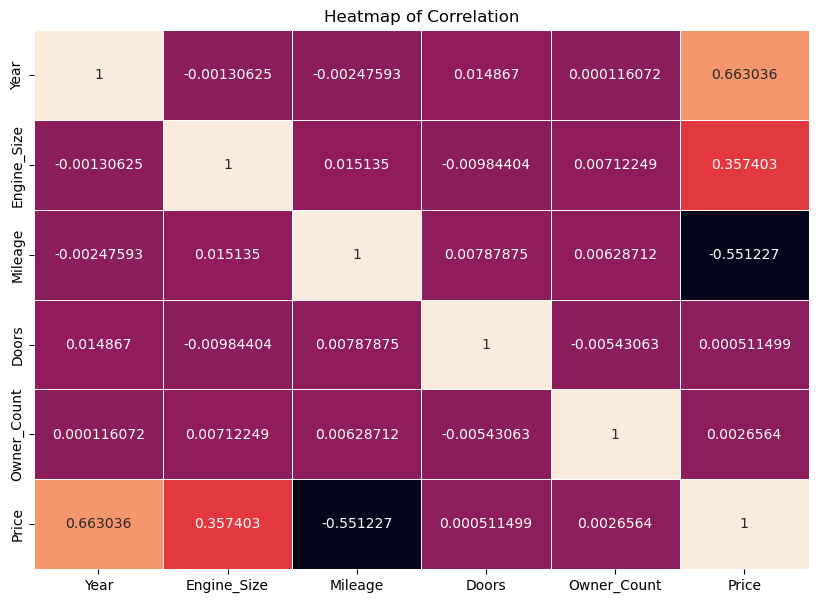

In [34]:
corr_df = df[["Year","Engine_Size","Mileage","Doors","Owner_Count","Price"]].corr()
plt.figure(figsize= (10,7))
sns.heatmap(corr_df,annot = True,fmt ="g", linewidths=.5, cbar=False)
plt.title("Heatmap of Correlation")
plt.show()

We can see that the year and engine size are the most positively correlated features with the price of the car. Mileage is the most negatively correlated feature with the price of the car.

In [37]:
df["Brand"].value_counts()

Brand
Ford          1048
Audi          1038
Volkswagen    1020
Honda         1009
Chevrolet     1003
BMW            999
Hyundai        995
Kia            976
Toyota         970
Mercedes       942
Name: count, dtype: int64

In [41]:
print(f"Number of unique models: {len(df['Model'].value_counts())}")

Number of unique models: 30


Now that we have a basic understanding of the data, we can start to preprocess the data for machine learning.

In [43]:
# show that that brand feature is not significant in price prediction
anova_result = stats.f_oneway(*(df[df["Brand"] == brand]["Price"] for brand in df["Brand"].unique()))
print("P-value of ANOVA Test between Brand and Price:", anova_result.pvalue)

P-value of ANOVA Test between Brand and Price: 0.19027637004777526


In [42]:
# show that that model feature is not significant in price prediction
anova_result = stats.f_oneway(*(df[df["Model"] == model]["Price"] for model in df["Model"].unique()))
print("P-value of ANOVA Test between Model and Price:", anova_result.pvalue)

P-value of ANOVA Test between Model and Price: 0.8177865225247964


Create One-Hot Encoded Features and Remove Brand and Model feautures (would create too many one-hot encoded features and would not be very significant in price prediction)

In [36]:
df_one_hot = pd.get_dummies(data = df , columns = ["Fuel_Type", "Transmission"], prefix = ["Fuel","Trans"],drop_first = True)
bool_columns = df_one_hot.select_dtypes(include = "bool").columns
df_one_hot[bool_columns] = df_one_hot[bool_columns].astype(int)
df_one_hot = df_one_hot.drop(columns = ["Brand","Model"]) 
df_one_hot.head()

,Year,Engine_Size,Mileage,Doors,Owner_Count,Price,Fuel_Electric,Fuel_Hybrid,Fuel_Petrol,Trans_Manual,Trans_Semi-Automatic
0,2020,4.2,289944,3,5,8501,0,0,0,1,0
1,2012,2.0,5356,2,3,12092,0,1,0,0,0
2,2020,4.2,231440,4,2,11171,0,0,0,0,0
3,2023,2.0,160971,2,1,11780,1,0,0,1,0
4,2003,2.6,286618,3,3,2867,0,1,0,0,1


Create Train and Test Set

In [50]:

X = df_one_hot.drop(columns=["Price"])
y = df_one_hot["Price"]

numeric_columns = ["Year", "Engine_Size", "Mileage", "Doors", "Owner_Count"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])  
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])  


print(f"Length of X_train: {len(X_train)}, length of X_test: {len(X_test)}")
print(f"length of y_train: {len(y_train)}, length of y_test: {len(y_test)}")
print(f"Number of features: {len(X_train.columns)}")
print(X_train.head())

Length of X_train: 8000, length of X_test: 2000
length of y_train: 8000, length of y_test: 2000
Number of features: 10
          Year  Engine_Size   Mileage     Doors  Owner_Count  Fuel_Electric  \
9254 -0.655377     0.176135 -1.333932  1.346373     0.709567              0   
1561 -0.220429     1.563621  0.870313 -1.352896    -1.401979              1   
1670 -0.800360    -0.951198 -1.570781 -0.453140     1.413416              0   
6087  1.084418    -1.124633  0.581575 -1.352896     0.005719              0   
6669 -0.945343     0.523006 -1.722892 -0.453140    -0.698130              0   

      Fuel_Hybrid  Fuel_Petrol  Trans_Manual  Trans_Semi-Automatic  
9254            1            0             0                     1  
1561            0            0             0                     1  
1670            1            0             0                     1  
6087            0            0             0                     1  
6669            0            1             0                 

Save the Preprocessed Data to data folder to be used for training and testing the model

In [51]:
X_train.to_csv("data/X_train.csv", index=False)
X_test.to_csv("data/X_test.csv", index=False)
y_train.to_csv("data/y_train.csv", index=False)
y_test.to_csv("data/y_test.csv", index=False)
